In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
leaves = gutenberg.raw('whitman-leaves.txt')
paradise = gutenberg.raw('milton-paradise.txt')

# Print the first 250 characters of Leaves.
print('\nRaw:\n', leaves[0:250])


Raw:
 [Leaves of Grass by Walt Whitman 1855]


Come, said my soul,
Such verses for my Body let us write, (for we are one,)
That should I after return,
Or, long, long hence, in other spheres,
There to some group of mates the chants resuming,
(Tallying Earth


In [4]:
# Utility function for standard text cleaning. Remove all text between square brackets, double hyphens & extra whitespace 
# by splitting and rejoining

def text_cleaner(text):
   
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.

leaves = gutenberg.raw('whitman-leaves.txt')
paradise = gutenberg.raw('milton-paradise.txt')

# The Chapter indicator is idiosyncratic

leaves = re.sub(r'Chapter \d+', '', leaves)
leaves = re.sub(r'CHAPTER .*', '', leaves)

paradise = re.sub(r'Chapter \d+', '', paradise)
paradise = re.sub(r'CHAPTER .*', '', paradise)
    
leaves = text_cleaner(leaves)
paradidse = text_cleaner(paradise)

# Ok, what's it look like now?
print('Chapter headings removed:\n', leaves[0:250])

Chapter headings removed:
 Come, said my soul, Such verses for my Body let us write, (for we are one,) That should I after return, Or, long, long hence, in other spheres, There to some group of mates the chants resuming, (Tallying Earth's soil, trees, winds, tumultuous waves,)


In [5]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
leaves_doc = nlp(leaves)
paradise_doc = nlp(paradise)

In [6]:
# Group into sentences.
leaves_sents = [[sent, 'Whitman'] for sent in leaves_doc.sents]
paradise_sents = [[sent, 'Milton'] for sent in paradise_doc.sents]

# Save the sentences as data frame.
sentences = pd.DataFrame(leaves_sents + paradise_sents)
sentences.head()

,0,1
0,"(Come, ,, said, my, soul, ,, Such, verses, for...",Whitman
1,"(That, should, I, after, return, ,, Or, ,, lon...",Whitman
2,"(Ever, with, pleas'd, smile, I, may, keep, on,...",Whitman
3,"(I, here, and, now, Signing, for, Soul, and, B...",Whitman
4,(One's),Whitman


In [7]:
# Utility function to create a list of the 2500 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2500)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
leaveswords = bag_of_words(leaves_doc)
paradisewords = bag_of_words(paradise_doc)

# Combine bags to create a set of unique words.
common_words = set(leaveswords + paradisewords)

In [8]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500


,crew,ecstasy,sit,foul,say,evolution,venerable,interior,dangerous,outline,...,interrupt,dream,pioneer,autumn,false,rough,moloch,virginia,text_sentence,text_source
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Come, ,, said, my, soul, ,, Such, verses, for...",Whitman
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(That, should, I, after, return, ,, Or, ,, lon...",Whitman
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Ever, with, pleas'd, smile, I, may, keep, on,...",Whitman
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, here, and, now, Signing, for, Soul, and, B...",Whitman
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(One's),Whitman


In [9]:
# bag of words random forest

from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.996173247521

Test set score: 0.961658841941


In [10]:
# random forest cross validation

from sklearn.model_selection import cross_val_score

cross_val_score(rfc, X_test, y_test, cv=10)

array([ 0.96354167,  0.97135417,  0.95572917,  0.96614583,  0.95833333,
        0.96866841,  0.96866841,  0.95300261,  0.95039164,  0.97120419])

In [11]:
# bag of words with linear regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(5749, 3799) (5749,)
Training set score: 0.983997216907

Test set score: 0.983046426708


In [12]:
# linear regression cross validation

cross_val_score(lr, X_test, y_test, cv=10)

array([ 0.99479167,  0.97916667,  0.97395833,  0.98177083,  0.9765625 ,
        0.9843342 ,  0.97911227,  0.98172324,  0.97911227,  0.9895288 ])

In [15]:
del X_train
del X_test

**The linear regression model performed slightly better than random forest.  The linear regression cross validation scores are more evenly distributed and are closer to the train score.  Each model performed well, and the cross validation scores showed the models performed consistently.**

In [16]:
#reading in the data, this time in the form of paragraphs
grass=gutenberg.paras('whitman-leaves.txt')

#processing
grass_paras=[]
for paragraph in grass:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    grass_paras.append(' '.join(para))

print(grass_paras[0:4])

['[ Leaves of Grass by Walt Whitman 1855 ]', "Come , said my soul , Such verses for my Body let us write , ( for we are one ,) That should I after return , Or , long , long hence , in other spheres , There to some group of mates the chants resuming , ( Tallying Earth ' s soil , trees , winds , tumultuous waves ,) Ever with pleas ' d smile I may keep on , Ever and ever yet the verses owning  as , first , I here and now Signing for Soul and Body , set to them my name ,", 'Walt Whitman', '[ BOOK I . INSCRIPTIONS ]']


In [17]:
X_train, X_test = train_test_split(grass_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,# use inverse document frequencies for weighting
                             norm=u'l2', # Apply a correction factor so longer paragraphs and shorter paragraphs get 
                                         # treated equally
                             smooth_idf=True # Add 1 to all document frequencies, as if an extra document existed that used every word once.  
                                             # Prevents divide-by-zero errors
                            )


# Applying the vectorizer

grass_paras_tfidf=vectorizer.fit_transform(grass_paras)
print("Number of features: %d" % grass_paras_tfidf.get_shape()[1])

#splitting into training and test sets

X_train_tfidf, X_test_tfidf= train_test_split(grass_paras_tfidf, test_size=0.4, random_state=0)


# Reshape vectorizer output into something readable

X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs

n = X_train_tfidf_csr.shape[0]

# list dictionaries, one per paragraph

tfidf_bypara = [{} for _ in range(0,n)]

#List of features

terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores

for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.

print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 4986
Original sentence: } Song of Prudence
Tf_idf vector: {'prudence': 0.82769588177439979, 'song': 0.56117691265206071}


In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Our SVD data reducer.  Reduce the feature space from 4986 to 130.

svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.

X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

# Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics

paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 29.7175707272
Component 0:
[ BOOK XXVIII ]    0.999571
[ BOOK XXXIV .     0.999571
[ BOOK XX .        0.999571
[ BOOK IX ]        0.999571
[ BOOK XXVII ]     0.999571
[ BOOK XI ]        0.999571
[ BOOK XXX .       0.999571
[ BOOK XIX .       0.999571
[ BOOK XXIII ]     0.999571
[ BOOK XXXI ]      0.999571
Name: 0, dtype: float64
Component 1:
Thanks in old age  thanks ere I go , For health , the midday sun , the impalpable air  for life , mere life , For precious ever - lingering memories , ( of you my mother dear  you , father  you , brothers , sisters , friends ,) For all my days  not those of peace alone  the days of war the same , For gentle words , caresses , gifts from foreign lands , For shelter , wine and meat  for sweet appreciation , ( You distant , dim unknown  or young or old  countless , unspecified , readers belov ' d , We never met , and neer shall meet  and yet our souls embrace , long , close and long ;) For beings , groups ,

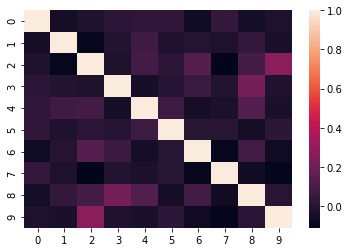

Key:
0 } On the Beach at Night
1 I need no assurances , I am a man who is preoccupied of his own soul ; I do not doubt that from under the feet and beside the hands and face I am cognizant of , are now looking faces I am not cognizant of , calm and actual faces , I do not doubt but the majesty and beauty of the world are latent in any iota of the world , I do not doubt I am limitless , and that the universes are limitless , in vain I try to think how limitless , I do not doubt that the orbs and the systems of orbs play their swift sports through the air on purpose , and that I shall one day be eligible to do as much as they , and more than they , I do not doubt that temporary affairs keep on and on millions of years , I do not doubt interiors have their interiors , and exteriors have their exteriors , and that the eyesight has another eyesight , and the hearing another hearing , and the voice another voice , I do not doubt that the passionately - wept deaths of young men are provided f

In [19]:
# Compute document similarity using LSA components

similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

# Only taking the first 10 sentences

sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]

# Make a plot

ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generate a key for the plot.

print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

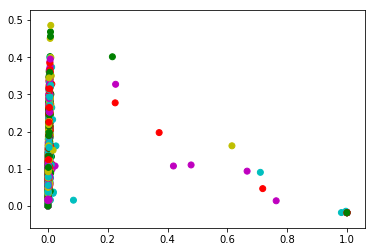

In [20]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_train_lsa)
nbrs.kneighbors_graph(X_train_lsa).toarray()

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c='mcygr')
plt.show()

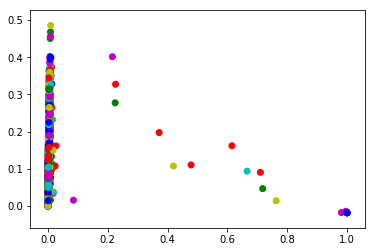

In [21]:
# graph k-means clusters

from sklearn.cluster import KMeans

# Calculate predicted values.
km = KMeans(n_clusters=6, random_state=42).fit_predict(X_train_lsa)

plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c='mcybgr')
plt.show()

In [22]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


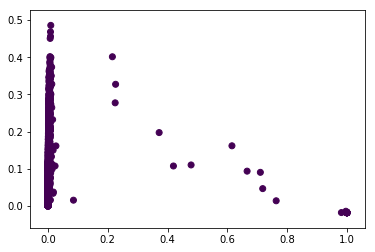

Comparing the assigned categories to the ones in the data:
col_0                                                  0
row_0                                                   
MeanShift(bandwidth=1.3673551571413245, bin_see...  1486


In [23]:
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(ms,labels))